# **Hospital Length of Stay (LOS) Prediction**


## **Problem Statement**

**Optimizing Resource Allocation in Hospital Management through Length of Stay Prediction**

In the context of the HealthPlus hospital's inefficient management system and the pressing need for better resource allocation, the primary problem revolves around accurately predicting the length of stay (LOS) for patients upon admission. Inefficient distribution of resources such as beds, ventilators, and staff has led to significant complications, resulting in both financial losses and compromised patient care.

## **Objective**

Develop a predictive model to estimate the length of stay (LOS) for patients admitted to HealthPlus hospital, enabling optimized resource planning and allocation.

## Data Dictionary

* **patientid**: Patient ID
* **Age**: Range of age of the patient
* **gender**: Gender of the patient
* **Type of Admission**: Trauma, emergency or urgent
* **Severity of Illness**: Extreme, moderate, or minor
* **health_condition**s: Any previous health conditions suffered by the patient
* **Visitors with Patient**: The number of patients who accompany the patient
* **Insurance**: Does the patient have health insurance or not?
* **Admission_Deposit**: The deposit paid by the patient during admission
* **Stay (in days)**: The number of days that the patient has stayed in the hospital. This is the **target variable**
* **Available Extra Rooms in Hospital**: The number of rooms available during admission
* **Department**: The department which will be treating the patient
* **Ward_Facility_Code**: The code of the ward facility in which the patient will be admitted
* **doctor_name**: The doctor who will be treating the patient
* **staff_available**: The number of staff who are not occupied at the moment in the ward

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

# To build models for prediction
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor

from sklearn import tree

# To check model performance
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error

In [2]:
# For tuning the model
from sklearn.model_selection import GridSearchCV

## Load Healthcare Data

In [3]:
# Read the healthcare dataset file
raw_data = pd.read_csv("healthcare_data.csv")

In [4]:
# Copy raw data into another variable to avoid alteration to original data
cpy_data = raw_data.copy()

## Data Overview

In [5]:
cpy_data.head()

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,NaN,4,No,4814.149231,8
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34


In [6]:
cpy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  500000 non-null  int64  
 1   Department                         500000 non-null  object 
 2   Ward_Facility_Code                 500000 non-null  object 
 3   doctor_name                        500000 non-null  object 
 4   staff_available                    500000 non-null  int64  
 5   patientid                          500000 non-null  int64  
 6   Age                                500000 non-null  object 
 7   gender                             500000 non-null  object 
 8   Type of Admission                  500000 non-null  object 
 9   Severity of Illness                500000 non-null  object 
 10  health_conditions                  348112 non-null  object 
 11  Visitors with Patient              5000

**Observations**

- There is a mix of numerical and categorical features within the dataset
- Patientid does appear to be useful for analysis, so it will be dropped

In [7]:
#Drop the patientid from data because it will not add value to the analysis
cpy_data = cpy_data.drop(columns=["patientid"])

In [8]:
# Check for duplicated entries
cpy_data.duplicated().sum()

0

In [9]:
# Get basic stats on the numerical features
cpy_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Available Extra Rooms in Hospital,500000.0,3.638800,2.698124,0.000000,2.000000,3.000000,4.000000,24.00000
staff_available,500000.0,5.020470,3.158103,0.000000,2.000000,5.000000,8.000000,10.00000
Visitors with Patient,500000.0,3.549414,2.241054,0.000000,2.000000,3.000000,4.000000,32.00000
Admission_Deposit,500000.0,4722.315734,1047.324220,1654.005148,4071.714532,4627.003792,5091.612717,10104.72639
Stay (in days),500000.0,12.381062,7.913174,3.000000,8.000000,9.000000,11.000000,51.00000


**Observations**

- On average there is 3 rooms available, with 5 staff members available
- On average there are 3 visitors per patient who say 12 days on average

In [10]:
# Get categorical variables
categorical_columns = cpy_data.select_dtypes(include=['object', 'category'])

print("Categorical columns:")
print(categorical_columns.columns.tolist())

Categorical columns:
['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 'gender', 'Type of Admission', 'Severity of Illness', 'health_conditions', 'Insurance']


In [11]:
# Get number of occurrences (percentage) of each unique value in each categorical column
for column in categorical_columns:
    print(cpy_data[column].value_counts(1))
    print("-" * 50)

Department
gynecology            0.686956
radiotherapy          0.168630
anesthesia            0.088358
TB & Chest disease    0.045780
surgery               0.010276
Name: proportion, dtype: float64
--------------------------------------------------
Ward_Facility_Code
F    0.241076
D    0.238110
B    0.207770
E    0.190748
A    0.093102
C    0.029194
Name: proportion, dtype: float64
--------------------------------------------------
doctor_name
Dr Sarah     0.199192
Dr Olivia    0.196704
Dr Sophia    0.149506
Dr Nathan    0.141554
Dr Sam       0.111422
Dr John      0.102526
Dr Mark      0.088820
Dr Isaac     0.006718
Dr Simon     0.003558
Name: proportion, dtype: float64
--------------------------------------------------
Age
21-30     0.319586
31-40     0.266746
41-50     0.160812
11-20     0.093072
61-70     0.053112
51-60     0.043436
71-80     0.037406
81-90     0.016362
0-10      0.006736
91-100    0.002732
Name: proportion, dtype: float64
------------------------------------------

**Observations**

- Gynecology department gets the most number of patients (~68%), whereas Surgery department gets the least (~1%)
- Majority of the patients are female (~74%)
- Over half (~56%) of the illness admitted to the hospital are considered moderate
- Over half (~62%) of the admission type is trauma
- Majority of patients belong to the agre group of 21-50 (~75%)
- Ward facilities A and C accommodate the leat number of patients (~12%)

**First take analysis**

- Given majoriy of the patients are female and gyncology department gets the most number of patients, I believe it's important to see what percentage of female patients are going to the gynecology department

In [12]:
department_of_interest = "gynecology"
gender_of_interest = "Female"

# Count the rows where both values are present in respective columns
count = ((cpy_data['Department'] == department_of_interest) & (cpy_data['gender'] == gender_of_interest)).sum()
total_count = cpy_data.shape[0]

print(count/total_count)

0.686956


**Observation**
~69% of all female visit are going to the gynecology department. This could potentially be a cause of long LOS as the hospital facility may not be equipe to handle large volume of patients visiting gynecology department

## Exploratory Data Analysis (EDA)

Now I will perform EDA specifically to target which variables affects LOS

In [13]:
# General function for plotting both boxplot and histogram per feature
def histogram_boxplot(data, feature, figsize=(8,6),kde=False,bins=None):
    fig, (ax_box, ax_hist) = plt.subplots(nrows=2, sharex=True, figsize=figsize, gridspec_kw={"height_ratios": (0.25, 0.75)})
    sns.boxplot(data=data,x=feature,ax=ax_box,showmeans=True,color="violet")
    sns.histplot(data=data,x=feature,kde=kde,ax=ax_hist,bins=bins,palette="winter") if bins else sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist
    )  
    ax_hist.axvline(data[feature].mean(), color="green", linestyle = "--") # Add mean to histogram
    ax_hist.axvline(data[feature].median(), color="black", linestyle = "-") # Add median to histogram

#### **Length of stay**

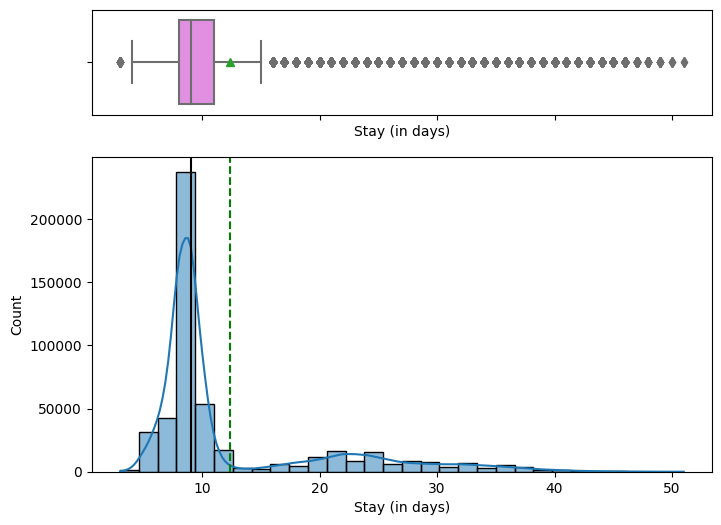

In [14]:
histogram_boxplot(cpy_data,"Stay (in days)",kde=True,bins=30)

#### **Admission Deposit**

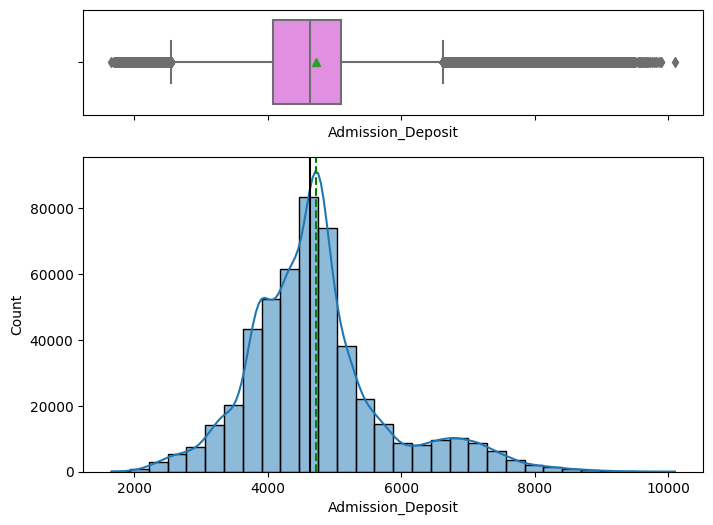

In [15]:
histogram_boxplot(cpy_data, "Admission_Deposit", kde = True, bins = 30)

#### **Visitors with Patients**

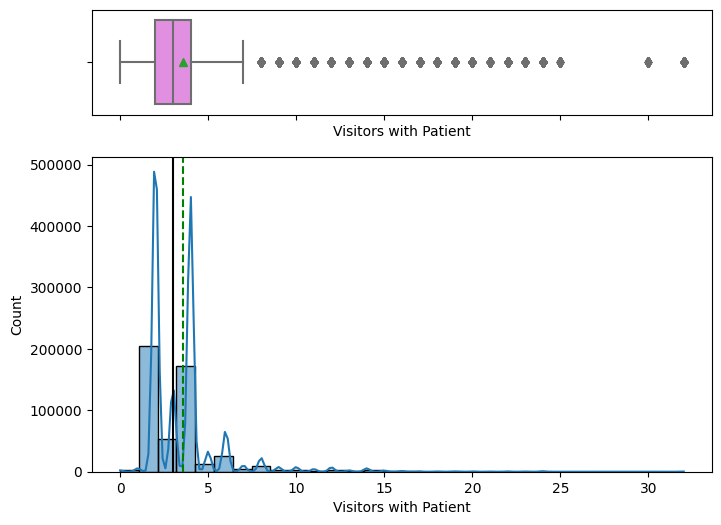

In [16]:
histogram_boxplot(cpy_data, "Visitors with Patient", kde = True, bins = 30)

<Axes: >

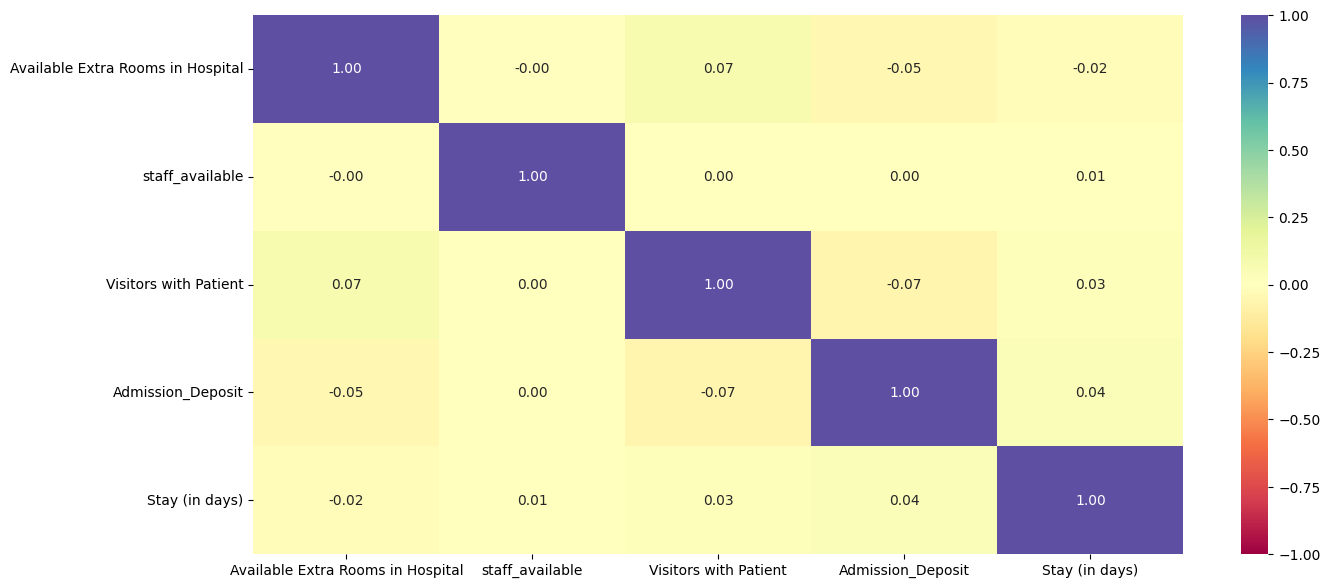

In [17]:
numeric_df = cpy_data.select_dtypes(include=['int','float'])
plt.figure(figsize = (15,7))
sns.heatmap(numeric_df.corr(), annot = True, vmin = -1, vmax = 1, fmt = ".2f", cmap = "Spectral")

**Observations**

- There seems to be no correlation between variables
- These continuous variables show no correlation with the target variable( stay(in days)). As such categorical variables might be more important for prediction

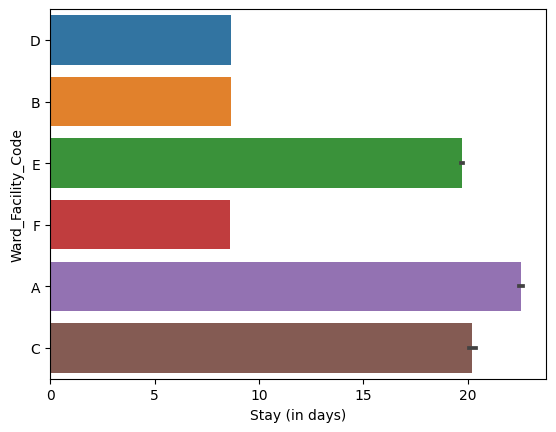

In [18]:
sns.barplot(y = 'Ward_Facility_Code', x = 'Stay (in days)', data = cpy_data)
plt.show()

**Observation**
- Wards A and C has patients staying for the longest duration, which may imply these wards are for patients with serious illnesses

In [19]:
def stacked_barplot(data, predictor, target):
    count = data[predictor].nunique()
    tab1 = pd.crosstab(data[predictor], data[target], margins = True)
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize = "index")
    tab.plot(kind = "bar", stacked = True, figsize = (count + 1, 5))
    plt.legend(
        loc = "lower left",
        frameon = False,
    )
    plt.legend(loc = "upper left", bbox_to_anchor = (1, 1))
    plt.show()

Department          TB & Chest disease  anesthesia  gynecology  radiotherapy  \
Ward_Facility_Code                                                             
A                                 4709       15611           0         21093   
B                                    0           0      103885             0   
C                                 1319        4199           0          9079   
D                                    0           0      119055             0   
E                                16862       24369           0         54143   
F                                    0           0      120538             0   
All                              22890       44179      343478         84315   

Department          surgery     All  
Ward_Facility_Code                   
A                      5138   46551  
B                         0  103885  
C                         0   14597  
D                         0  119055  
E                         0   95374  
F            

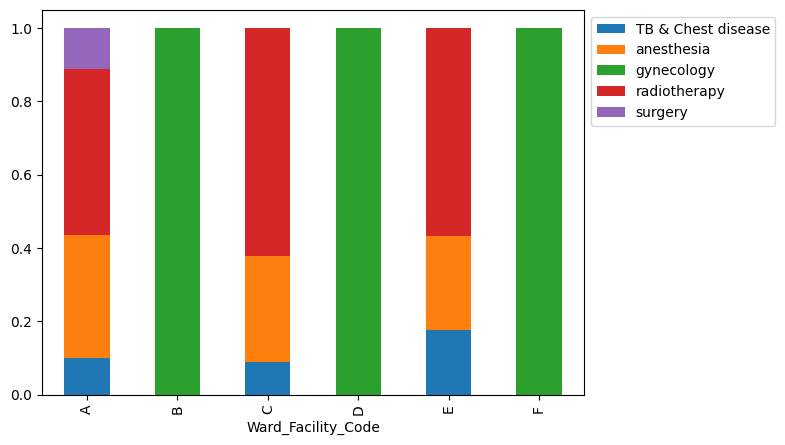

In [20]:
stacked_barplot(cpy_data, "Ward_Facility_Code", "Department")

**Observations**

- Wards B, D, and F dedicated to gynecology department
- Patients requiring surgery are all going to ward A

Severity of Illness  Extreme   Minor  Moderate     All
Ward_Facility_Code                                    
A                      13662    7877     25012   46551
B                      24222   23579     56084  103885
C                       3503    3013      8081   14597
D                      29549   27220     62286  119055
E                      11488   22254     61632   95374
F                       5842   47594     67102  120538
All                    88266  131537    280197  500000
------------------------------------------------------------------------------------------------------------------------


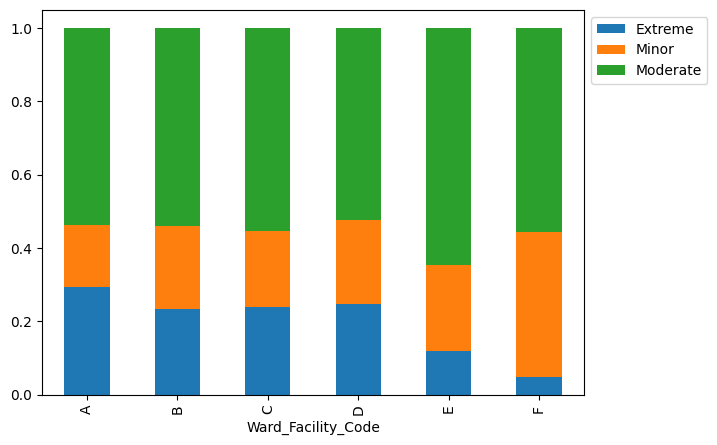

In [21]:
stacked_barplot(cpy_data, "Ward_Facility_Code", "Severity of Illness")

## Data Preparation for Model Building

In [22]:
# Convert categorial vairables into dummy/indicator variables
temp_data = pd.get_dummies(
    cpy_data,
    columns = cpy_data.select_dtypes(include = ["object", "category"]).columns.tolist(),
    drop_first = True,
)

In [23]:
temp_data.head()

,Available Extra Rooms in Hospital,staff_available,Visitors with Patient,Admission_Deposit,Stay (in days),Department_anesthesia,Department_gynecology,Department_radiotherapy,Department_surgery,Ward_Facility_Code_B,...,gender_Other,Type of Admission_Trauma,Type of Admission_Urgent,Severity of Illness_Minor,Severity of Illness_Moderate,health_conditions_Diabetes,health_conditions_Heart disease,health_conditions_High Blood Pressure,health_conditions_Other,Insurance_Yes
0,4,0,4,2966.408696,8,False,True,False,False,False,...,False,True,False,False,False,True,False,False,False,True
1,4,2,2,3554.835677,9,False,True,False,False,True,...,False,True,False,True,False,False,True,False,False,False
2,2,8,2,5624.733654,7,False,True,False,False,True,...,False,True,False,False,False,True,False,False,False,True
3,4,7,4,4814.149231,8,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,False
4,2,10,2,5169.269637,34,True,False,False,False,False,...,False,True,False,False,True,True,False,False,False,False


In [24]:
# Split independent and target variables

x = temp_data.drop('Stay (in days)',axis=1)
y = temp_data['Stay (in days)']

In [25]:
# Splitting the dataset into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 1)

In [26]:
# Checking the shape of the train and test data
print("Shape of Training set : ", x_train.shape)
print("Shape of test set : ", x_test.shape)

Shape of Training set :  (400000, 41)
Shape of test set :  (100000, 41)


## Model Building

**Objective**

- We will be constructing mutliple models to predict LOS and compare with each other to determine the best model

Create a general function to calculate meitrics (RMSE,MAE,R2,Adjusted R2, and MAPE)

In [27]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    pred = model.predict(predictors)                  # Predict using the independent variables
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE
    mape = mape_score(target, pred)                   # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf



## Decision Tree

In [28]:
features = list(x.columns)

dt_regressor = DecisionTreeRegressor(random_state=1, max_depth=3)

dt_regressor.fit(x_train,y_train)

dt_regressor_perf_test = model_performance_regression(dt_regressor,x_test,y_test)

print(dt_regressor_perf_test)


       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  3.058892  1.879155   0.851417        0.851356  14.53351


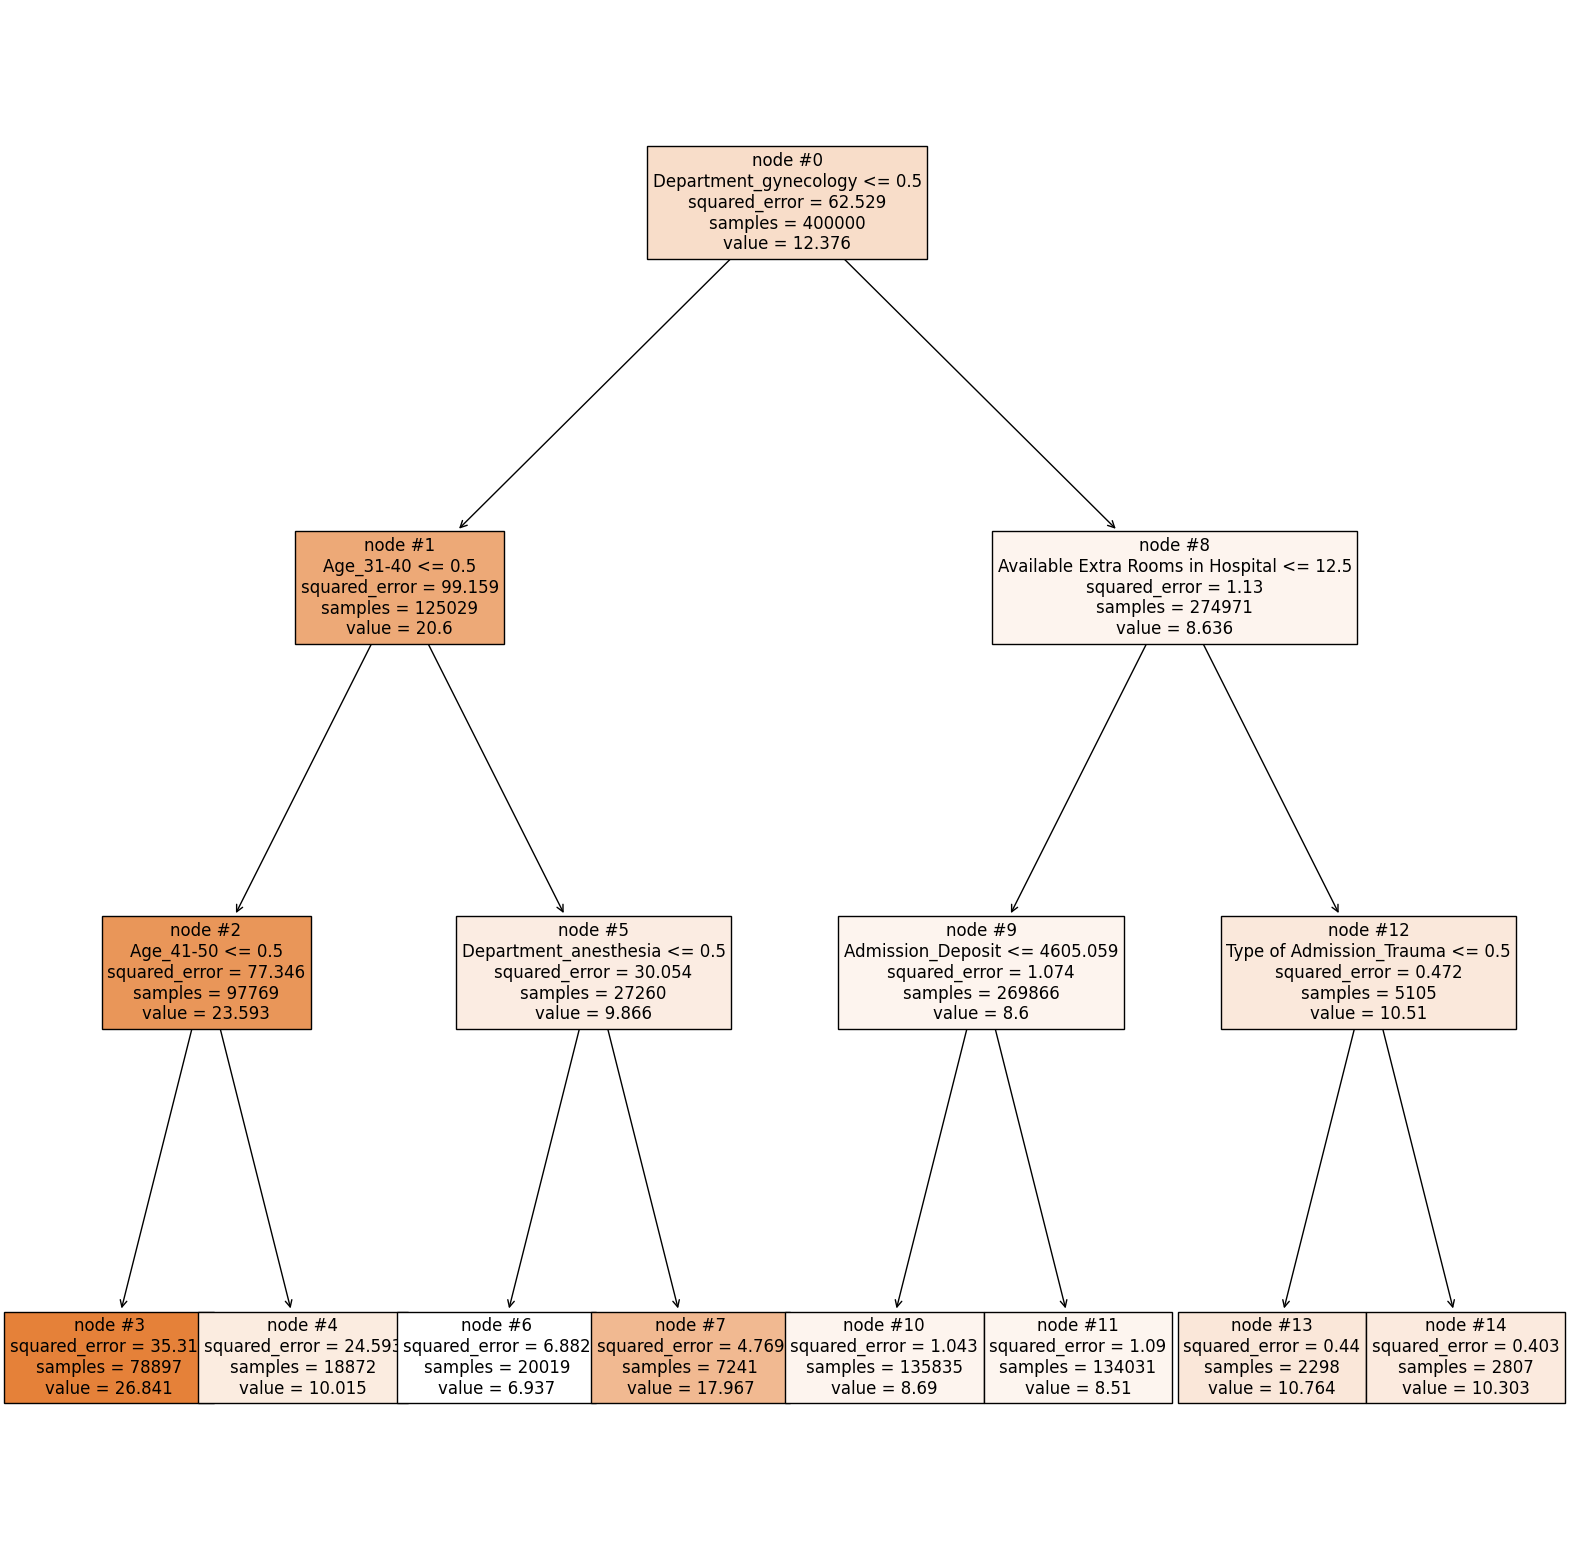

In [29]:
plt.figure(figsize = (20, 20))
tree.plot_tree(dt_regressor, feature_names = features, filled = True, node_ids = True, fontsize=12)
plt.show()

In [30]:
print(tree.export_text(dt_regressor, feature_names=x_train.columns.tolist(), show_weights=True))

|--- Department_gynecology <= 0.50
|   |--- Age_31-40 <= 0.50
|   |   |--- Age_41-50 <= 0.50
|   |   |   |--- value: [26.84]
|   |   |--- Age_41-50 >  0.50
|   |   |   |--- value: [10.02]
|   |--- Age_31-40 >  0.50
|   |   |--- Department_anesthesia <= 0.50
|   |   |   |--- value: [6.94]
|   |   |--- Department_anesthesia >  0.50
|   |   |   |--- value: [17.97]
|--- Department_gynecology >  0.50
|   |--- Available Extra Rooms in Hospital <= 12.50
|   |   |--- Admission_Deposit <= 4605.06
|   |   |   |--- value: [8.69]
|   |   |--- Admission_Deposit >  4605.06
|   |   |   |--- value: [8.51]
|   |--- Available Extra Rooms in Hospital >  12.50
|   |   |--- Type of Admission_Trauma <= 0.50
|   |   |   |--- value: [10.76]
|   |   |--- Type of Admission_Trauma >  0.50
|   |   |   |--- value: [10.30]



**Observations**

- Root node, is gynecology department which results in the highest information gain among all features

**Interpretation and Conclusions**

- The decision tree starts with a split on the Department_gynecology feature. If the patient was not admitted to the gynecology department, the tree proceeds to consider the patient's age and the department of anesthesia. 
- The Model predicts the following conditions to lead to the longest LOS
    - If the patient is not admitted to the department of gynecology and is not between 31-50 years old, then the predicted LOS for the patient is ~27 days. 
    - If the patient is not admitted to the department of gynecology and is between 31-40 and did go to the anesthesia department then the predicted LOS for patient is ~18 days


## Bagging Regressor

In [31]:
# Bagging Regressor
bagging_estimator = BaggingRegressor(random_state = 1)

# Fit model
bagging_estimator.fit(x_train,y_train)

bagging_performance_test = model_performance_regression(bagging_estimator,x_test,y_test)

bagging_performance_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.364505,0.902326,0.970434,0.970422,7.627444


## Random Forest Regressor

In [32]:
# Random Forets Regressor
random_forest_estimator = RandomForestRegressor(n_estimators=50, random_state=1)

# Fitting the model
random_forest_estimator.fit(x_train,y_train)

random_forest_test = model_performance_regression(random_forest_estimator,x_test,y_test)

random_forest_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.30924,0.868013,0.97278,0.972769,7.33985


## Comparing Between Models

In [33]:
models_df = pd.concat(
    [
        random_forest_test.T,
        bagging_performance_test.T,
        dt_regressor_perf_test.T
    ],
    axis=1,
)

models_df.columns = [
    "Random Forest Regressor",
    "Bagging Regressor",
    "Decision Tress Regressor"
]

models_df.T

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Random Forest Regressor,1.309240,0.868013,0.972780,0.972769,7.339850
Bagging Regressor,1.364505,0.902326,0.970434,0.970422,7.627444
Decision Tress Regressor,3.058892,1.879155,0.851417,0.851356,14.533510


**Observations:**

- Random Forest Regressor appears to have the better RMSE and MAE score compared to the rest. As such, we will look to further improve upon this model through tuning

## Tune Random Forest Regressor

In [34]:
random_forest_tuned = RandomForestRegressor(random_state=1)

# Grid of parameters
random_forest_parameters = {
    "n_estimators": [50,75],
    "max_depth": [3,7],
    "max_features": [0.5,1]
}

rf_grid_obj = GridSearchCV(random_forest_tuned,random_forest_parameters,scoring = 'neg_mean_squared_error',cv=5)

rf_grid_obj = rf_grid_obj.fit(x_train, y_train)

# Set the rf_tuned_regressor to the best combination of parameters
rf_tuned_regressor = rf_grid_obj.best_estimator_

rf_tuned_regressor.fit(x_train, y_train)

# Model Performance on the test data
rf_tuned_regressor_perf_test = model_performance_regression(rf_tuned_regressor, x_test, y_test)

rf_tuned_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.755585,1.186906,0.951058,0.951038,10.040201


In [35]:
print(rf_grid_obj.best_estimator_)

RandomForestRegressor(max_depth=7, max_features=0.5, n_estimators=50,
                      random_state=1)


**Observations**

Tuning Random Forest Regressor model did not appear to improve the overall model. This is due to to the limited number of parameter inputs I provided. For the sake of this exercise, I will not input more parameter inputs for more testing, as it's too computationally expensive and time consuming

## Visualize Feature Importance

In [36]:
features = list(cpy_data.columns)

importance = random_forest_estimator.feature_importances_

indices = np.sort(importance)

plt.figure(figsize = (10, 10))

plt.title('Feature Importances')

plt.barh(range(len(indices)), importance[indices], color = 'blue', align = 'center')

plt.yticks(range(len(indices)), [features[i] for i in indices])

plt.xlabel('Relative Importance')

plt.show()

## Business Insights and Recommendations